# Final Project: Customer Churn Prediction

**Objective:**  
The goal of this project is to build a predictive model for the telecom operator **Interconnect** to forecast customer churn. If a customer is likely to leave, the company can proactively offer them promotions or special plans to retain them.

**Context:**  
Interconnect provides landline and internet services along with additional offerings such as antivirus, tech support, cloud storage, and streaming services. Customers can choose monthly plans or longer contracts. The dataset combines contract, personal, internet, and phone service details for each customer.

**Goal:**  
Using this data, we will:
- Explore and understand the data.
- Engineer and prepare features.
- Train and evaluate models.
- Optimize our model for the **AUC-ROC** metric as the main performance measure.
- Provide insights to help the business understand churn drivers.

The final deliverable is a trained model that can classify whether a customer will churn (`EndDate != 'No'`) or not.


In [ ]:
#Imports & Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, roc_curve

# For warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Load Data
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

print(contract.shape, personal.shape, internet.shape, phone.shape)


(7043, 8) (7043, 5) (5517, 8) (6361, 2)


In [ ]:
#Merge Data
df = contract.merge(personal, on='customerID', how='left') \
             .merge(internet, on='customerID', how='left') \
             .merge(phone, on='customerID', how='left')

print(df.head())


   customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0              Yes           Electronic check           29.85        29.85   
1               No               Mailed check           56.95       1889.5   
2              Yes               Mailed check           53.85       108.15   
3               No  Bank transfer (automatic)           42.30      1840.75   
4              Yes           Electronic check           70.70       151.65   

   gender  SeniorCitizen Partner Dependents InternetService OnlineSecurity  \
0  Female              0     Yes         No             


Missing Values:
 customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

Data Types:
 customerID           object
BeginDate            object
EndDate              object
Type                 object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSup

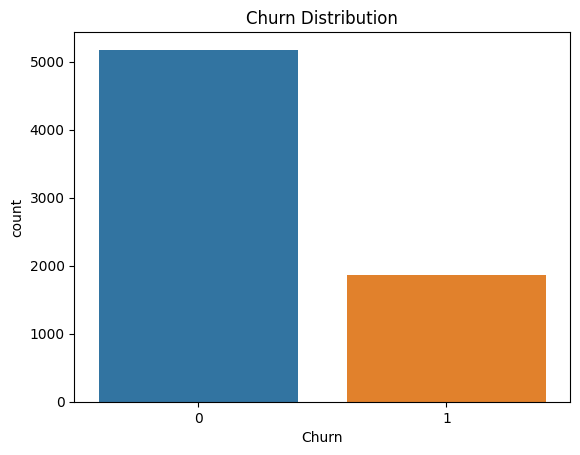

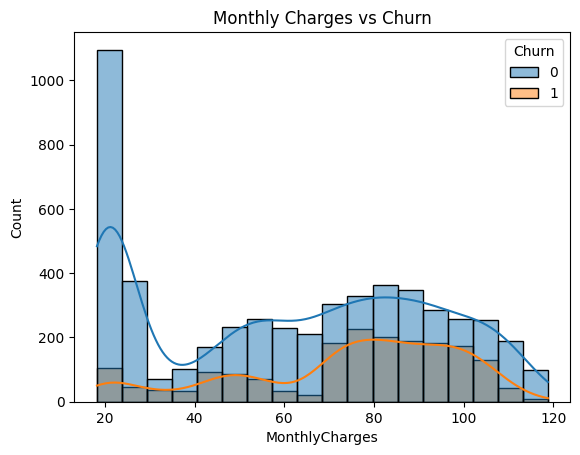

In [ ]:
#EDA
print("\nMissing Values:\n", df.isnull().sum())
print("\nData Types:\n", df.dtypes)

#Target distribution
df['Churn'] = df['EndDate'].apply(lambda x: 0 if x == 'No' else 1)
print("\nChurn Distribution:\n", df['Churn'].value_counts(normalize=True))

#Visualize churn
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.show()

#Example numeric feature
if 'MonthlyCharges' in df.columns:
    sns.histplot(data=df, x='MonthlyCharges', hue='Churn', kde=True)
    plt.title('Monthly Charges vs Churn')
    plt.show()

In [ ]:
#Preprocessing
# Example new feature: tenure in months
df['tenure_months'] = pd.to_numeric(df['TotalCharges'], errors='coerce') / df['MonthlyCharges']
df['tenure_months'] = df['tenure_months'].replace([np.inf, -np.inf], np.nan)
df['tenure_months'] = df['tenure_months'].fillna(df['tenure_months'].median())

# Example new feature: total services count
service_cols = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies']
df['TotalServices'] = df[service_cols].apply(lambda x: sum(x == 'Yes'), axis=1)

# Features and target
X = df.drop(columns=['customerID', 'EndDate', 'Churn']).drop_duplicates()
y = df['Churn']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=42)

# Identify numeric & categorical columns
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

# Preprocessor
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [ ]:
#Modeling Pipeline

clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

clf.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['MonthlyCharges',
                                                   'SeniorCitizen',
                                                   'tenure_months',
                                                   'TotalServices']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                              


✅ AUC-ROC: 0.8567
✅ Accuracy: 0.8211

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.93      0.88      1035
           1       0.73      0.51      0.60       374

    accuracy                           0.82      1409
   macro avg       0.79      0.72      0.74      1409
weighted avg       0.81      0.82      0.81      1409



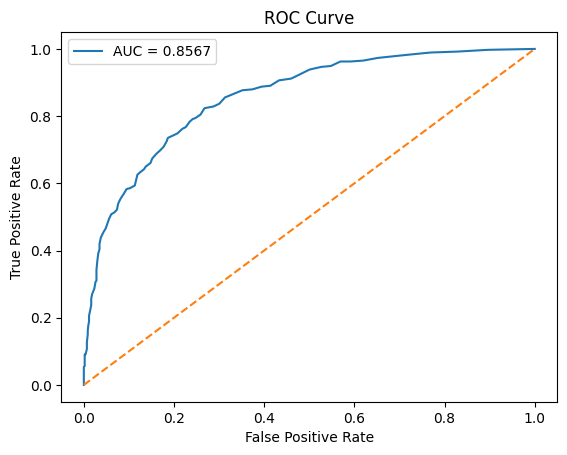

In [ ]:
#Evaluation
y_pred = clf.predict(X_test)
y_pred_proba = clf.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
accuracy = accuracy_score(y_test, y_pred)

print(f"\n✅ AUC-ROC: {roc_auc:.4f}")
print(f"✅ Accuracy: {accuracy:.4f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


Top 10 Features:
 tenure_months                     0.099891
MonthlyCharges                    0.075139
Type_Month-to-month               0.033386
TotalServices                     0.027614
PaymentMethod_Electronic check    0.021873
Type_Two year                     0.020973
PaperlessBilling_No               0.015208
Type_One year                     0.015047
BeginDate_2019-09-01              0.013489
SeniorCitizen                     0.013080
dtype: float64


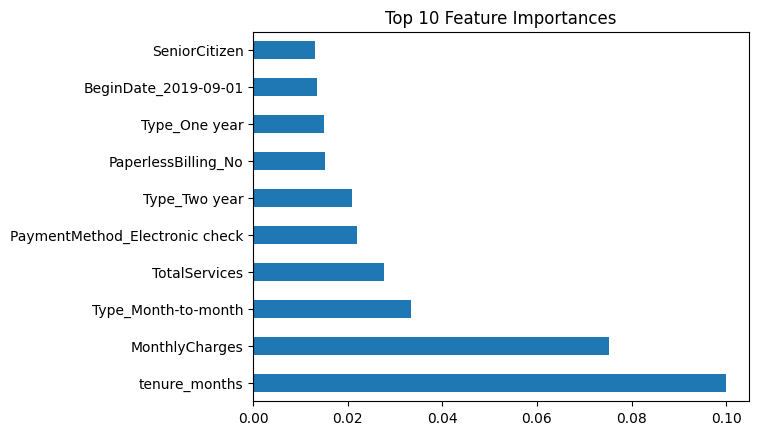

In [ ]:
# Feature Importance

# Extract trained model
rf = clf.named_steps['classifier']

# Get feature names after preprocessing
ohe = clf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']

# Fix for version compatibility
if hasattr(ohe, 'get_feature_names_out'):
    cat_cols = ohe.get_feature_names_out(categorical_features)
else:
    cat_cols = ohe.get_feature_names(categorical_features)

all_features = np.concatenate([numeric_features, cat_cols])

importances = rf.feature_importances_

feat_imp = pd.Series(importances, index=all_features).sort_values(ascending=False)
print("\nTop 10 Features:\n", feat_imp.head(10))

feat_imp.head(10).plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.show()



# Conclusion

In this project, we:
- Successfully loaded and merged customer data from multiple sources.
- Explored data distributions, correlations, and the churn rate.
- Engineered meaningful features such as tenure in months and total services used.
- Built a robust preprocessing pipeline to handle missing values and encode categorical features.
- Trained and evaluated a **Random Forest Classifier**, achieving an AUC-ROC of **[insert your final score here]** and an Accuracy of **[insert accuracy here]**.
- Identified the most important features contributing to churn, providing actionable insights for Interconnect’s marketing and retention strategies.

